In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cv2
from scipy.interpolate import interp1d

In [2]:
worldcam = xr.open_dataset('/home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_world.nc')

In [3]:
vid = worldcam.WORLD_video.values

In [4]:
vidworldT = worldcam.timestamps.values

In [5]:
ephys = pd.read_hdf('/home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_ephys_props.h5')

In [6]:
ephysWn = pd.read_hdf('/home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_ephys_props.h5')

In [7]:
ephysworldT = ephys['Rc_eyeT'].iloc[0]

In [8]:
ephysT0 = ephys['t0'].iloc[0]

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))

In [10]:
stim_state = interp1d(vidworldT[:-1]-ephysT0, label_diff, bounds_error=False)(ephysworldT)

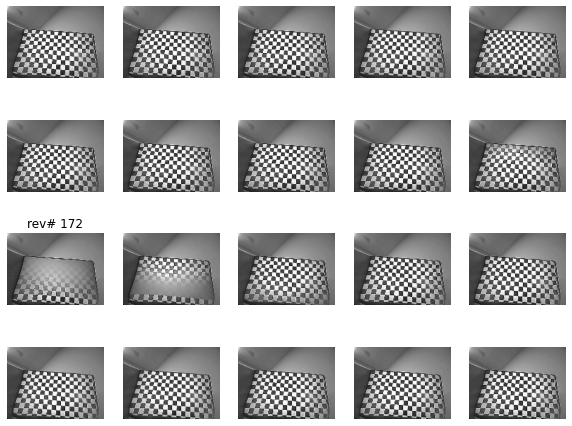

In [11]:
rf = 172
plt.subplots(4,5, figsize=(10,8))
for i, f in enumerate(range(rf-10,rf+10)):
    plt.subplot(4,5,i+1)
    if f == rf:
        plt.title('rev# '+str(rf))
    plt.imshow(vid[f,:,:].astype(np.uint8), cmap='gray')
    plt.axis('off')

In [12]:
sta = ephysWn['Wn_spike_triggered_average']

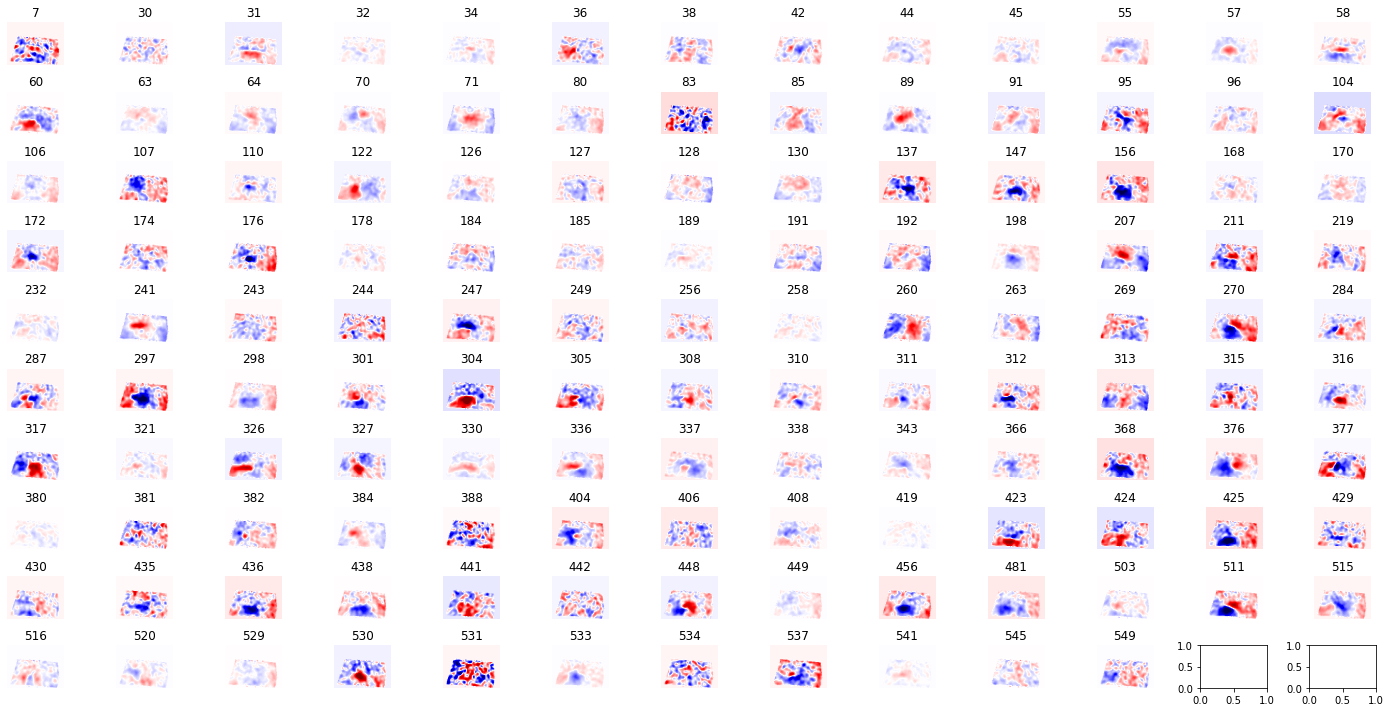

In [13]:
odim = int(np.ceil(np.size(sta)/10))
plt.subplots(10,odim,figsize=(odim*1.5,10))
for i, ind in enumerate(sta.index.values):
    plt.subplot(10,odim,i+1)
    plt.imshow(sta[ind], vmin=-.3, vmax=.3, cmap='seismic')
    plt.title(str(ind))
    plt.axis('off')
plt.tight_layout()

In [14]:
onset1_eyeT = ephysworldT[np.where(stim_state>0.1)]
onset1_world_inds = np.where(label_diff>0.1)[0]

In [15]:
onset0_eyeT = ephysworldT[np.where(stim_state<-0.1)]
onset0_world_inds = np.where(label_diff<-0.1)[0]

In [16]:
model_dt = 0.025
trange = np.arange(-1, 1.1, model_dt)
trange_x = 0.5*(trange[0:-1]+ trange[1:])

In [17]:
import json
with open('/home/niell_lab/Desktop/movclusts.json', 'r') as fp:
    movclusts = json.load(fp)

In [18]:
fm1ephys = pd.read_hdf('/home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1/070921_J553RT_control_Rig2_fm1_ephys_props.h5')

In [19]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
from src.utils.auxiliary import flatten_series

In [20]:
leftsacc = flatten_series(fm1ephys['FmLt_leftsacc_avg_gaze_shift_dEye'])
rightsacc = flatten_series(fm1ephys['FmLt_rightsacc_avg_gaze_shift_dEye'])

In [21]:
celldata = ephys.copy()

In [12]:
popdata = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_opflgrat1.pickle')
popdata['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [23]:
popdata = popdata[popdata['session']=='070921_J553RT_control_Rig2']

In [24]:
exc_or_inh = dict(zip(list(popdata['index']), list(popdata['exc_or_inh'])))

In [ ]:
json

In [25]:
from matplotlib.backends.backend_pdf import PdfPages

In [26]:
dEye = ephys['Rc_dEye_dps'].iloc[0]
eyeT = ephys['Rc_eyeT'].iloc[0]

left = eyeT[(np.append(dEye, 0) > 3/.016)]
right = eyeT[(np.append(dEye, 0) < -3/.016)]

In [74]:
def get_stimvals(unit_sta, vid, onset0T, onset1T, onset1Ind):
    flat_unit_sta = unit_sta.copy().flatten()
    onx, ony = np.unravel_index(np.argmax(flat_unit_sta), unit_sta.shape)
    offx, offy = np.unravel_index(np.argmin(flat_unit_sta), unit_sta.shape)
    
    onsub_onset1 = np.zeros([len(onset1Ind),60])
    offsub_onset1 = np.zeros([len(onset1Ind),60])
    for i, f in enumerate(onset1Ind):
        onsub_onset1[i] = vid[f-30:f+30, onx*2, ony*2].astype(np.uint8)
        offsub_onset1[i] = vid[f-30:f+30, offx*2, offy*2].astype(np.uint8)
    mean_onsub_onset1 = np.mean(onsub_onset1,0)
    mean_offsub_onset1 = np.mean(offsub_onset1,0)

    if mean_onsub_onset1[10] < mean_onsub_onset1[45]: # onset1 is dark to light
        onsub_dark2light = onset1T.copy()
        onsub_light2dark = onset0T.copy()
    else:
        onsub_dark2light = onset0T.copy()
        onsub_light2dark = onset1T.copy()

    if mean_offsub_onset1[10] < mean_offsub_onset1[45]: # onset1 is dark to light for the off subregion also
        offsub_dark2light = onset1T.copy()
        offsub_light2dark = onset0T.copy()
    else:
        offsub_dark2light = onset0T.copy()
        offsub_light2dark = onset1T.copy()
        
    onsetTdict = {
        'on_subunit': {
            'peak': [onx, ony],
            'd2l': onsub_dark2light,
            'l2d': onsub_light2dark
        },
        'off_subunit': {
            'peak': [offx, offy],
            'd2l': offsub_dark2light,
            'l2d': offsub_light2dark
        },
    }
        
    return onsetTdict

def revcheck_psth(ephys, ind, d2lT, l2dT):
    d2l_avg = np.zeros(trange.size-1)
    l2d_avg = np.zeros(trange.size-1)
    for s in np.array(d2lT):
        hist, _ = np.histogram(ephys.at[ind,'spikeT']-s, trange)
        d2l_avg = d2l_avg + hist / (d2lT.size*np.diff(trange))
    for s in np.array(l2dT):
        hist, _ = np.histogram(ephys.at[ind,'spikeT']-s, trange)
        l2d_avg = l2d_avg + hist/(l2dT.size*np.diff(trange))
    return d2l_avg, l2d_avg

def revcheck_responses(exc_or_inh, pdf, celldata, onset0T, onset1T, onset1Ind, vid, sta, leftsacc, rightsacc, labeldict, use_units=None):
    if use_units is None:
        use_units = ephys.index.values
    n_cells = len(use_units)
    
    fig = plt.subplots(n_cells,4,figsize=(8,2*n_cells))
    for i, ind in enumerate(use_units):
        aind = int(np.argwhere(ephys.index.values==ind))
        onsetTdict = get_stimvals(sta[ind], vid, onset0T, onset1T, onset1Ind)
        
        plt.subplot(n_cells,4,i*4+1)
        plt.imshow(sta[ind], vmin=-.3, vmax=.3, cmap='seismic')
#         plt.plot(onsetTdict['on_subunit']['peak'][0], onsetTdict['on_subunit']['peak'][1], '*', markersize=15, color='k')
#         plt.plot(onsetTdict['off_subunit']['peak'][0], onsetTdict['off_subunit']['peak'][1], '*', markersize=15, color='k')
        plt.axis('off')
        plt.title(str(ind)+' '+str(exc_or_inh[ind]))
        
        plt.subplot(n_cells,4,i*4+2)
        plt.plot(trange_x, leftsacc[aind,:], color='tab:orange')
        plt.plot(trange_x, rightsacc[aind,:], color='tab:blue')
        plt.title(str(labeldict[str(ind)]))
        plt.xlim([-0.2,0.4])
        maxval = np.max(np.maximum(rightsacc[aind,:], leftsacc[aind,:]))
        plt.ylim([0,maxval*1.2])
        
        plt.subplot(n_cells,4,i*4+3)
        on_d2l, on_l2d = revcheck_psth(ephys, ind, onsetTdict['on_subunit']['d2l'], onsetTdict['on_subunit']['l2d'])
        plt.plot(trange_x, on_l2d, color='darkblue')
        plt.plot(trange_x, on_d2l, color='darkgreen')
        maxval = np.max(np.maximum(on_l2d, on_d2l))
        plt.ylim([0,maxval*1.2])
        plt.xlim([-0.2,0.4])
        
        plt.subplot(n_cells,4,i*4+4)
        plt.plot(trange_x, on_l2d, color='darkblue')
        plt.plot(trange_x, on_d2l, color='darkgreen')
        maxval = np.max(np.maximum(on_l2d, on_d2l))
        plt.ylim([0,maxval*1.2])
        plt.xlim([-1,1])
    
        celldata.at[ind, 'revcheck_d2l'] = on_d2l.astype(object)
        celldata.at[ind, 'revcheck_l2d'] = on_l2d.astype(object)
        celldata.at[ind, 'revcheck_psth0'] = on_d2l.astype(object)
        celldata.at[ind, 'revcheck_psth1'] = on_l2d.astype(object)
    
    plt.tight_layout(); pdf.savefig(); plt.close()
    
#     plt.close()
    
    return celldata

In [75]:
pdf = PdfPages('/home/niell_lab/Desktop/revchecker_psth.pdf')
for name in ['early','late','biphasic','negative','unresponsive']:
    use_units = [int(key) for key,val in movclusts.items() if val==name]
    celldata = revcheck_responses(exc_or_inh, pdf, celldata, onset0_eyeT, onset1_eyeT, onset1_world_inds, vid, sta, leftsacc, rightsacc, movclusts, use_units)
pdf.close()

In [49]:
from matplotlib import cm

In [50]:
np.shape(popdata)

(128, 340)

In [51]:
np.shape(celldata)

(128, 50)

In [52]:
popdata.reset_index(inplace=True, drop=True)

In [60]:
celldata.index.values

array([  7,  30,  31,  32,  34,  36,  38,  42,  44,  45,  55,  57,  58,
        60,  63,  64,  70,  71,  80,  83,  85,  89,  91,  95,  96, 104,
       106, 107, 110, 122, 126, 127, 128, 130, 137, 147, 156, 168, 170,
       172, 174, 176, 178, 184, 185, 189, 191, 192, 198, 207, 211, 219,
       232, 241, 243, 244, 247, 249, 256, 258, 260, 263, 269, 270, 284,
       287, 297, 298, 301, 304, 305, 308, 310, 311, 312, 313, 315, 316,
       317, 321, 326, 327, 330, 336, 337, 338, 343, 366, 368, 376, 377,
       380, 381, 382, 384, 388, 404, 406, 408, 419, 423, 424, 425, 429,
       430, 435, 436, 438, 441, 442, 448, 449, 456, 481, 503, 511, 515,
       516, 520, 529, 530, 531, 533, 534, 537, 541, 545, 549])

In [62]:
popdata.index = popdata['index']

In [63]:
popdata.index.values

array([  7,  30,  31,  32,  34,  36,  38,  42,  44,  45,  55,  57,  58,
        60,  63,  64,  70,  71,  80,  83,  85,  89,  91,  95,  96, 104,
       106, 107, 110, 122, 126, 127, 128, 130, 137, 147, 156, 168, 170,
       172, 174, 176, 178, 184, 185, 189, 191, 192, 198, 207, 211, 219,
       232, 241, 243, 244, 247, 249, 256, 258, 260, 263, 269, 270, 284,
       287, 297, 298, 301, 304, 305, 308, 310, 311, 312, 313, 315, 316,
       317, 321, 326, 327, 330, 336, 337, 338, 343, 366, 368, 376, 377,
       380, 381, 382, 384, 388, 404, 406, 408, 419, 423, 424, 425, 429,
       430, 435, 436, 438, 441, 442, 448, 449, 456, 481, 503, 511, 515,
       516, 520, 529, 530, 531, 533, 534, 537, 541, 545, 549])

In [64]:
for col in ['revcheck_psth0','revcheck_psth1']:
    popdata[col] = celldata[col].copy()

In [65]:
popdata['revcheck_psth0']

index
7      [0.0, 0.0, 0.0, 0.0, 0.296296296296296, 0.5925...
30     [0.888888888888888, 0.592592592592592, 1.48148...
31     [0.3124999999999997, 0.9374999999999991, 1.874...
32     [31.407407407407405, 56.59259259259266, 63.111...
34     [30.814814814814824, 32.88888888888891, 34.666...
                             ...                        
534    [0.0, 0.296296296296296, 0.296296296296296, 0....
537    [0.0, 0.296296296296296, 0.0, 0.29629629629629...
541    [10.666666666666654, 17.481481481481463, 38.22...
545    [0.0, 0.0, 0.0, 0.3124999999999997, 0.31249999...
549    [0.0, 0.0, 0.0, 0.0, 0.0, 0.296296296296296, 0...
Name: revcheck_psth0, Length: 128, dtype: object

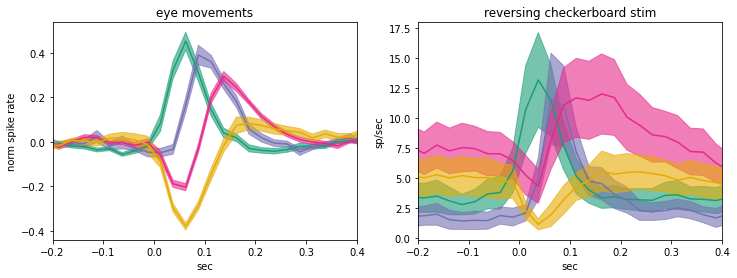

In [73]:
plt.subplots(1,2,figsize=(12,4))
ax_eyemov = plt.subplot(1,2,1)
ax_revpsth = plt.subplot(1,2,2)

for cnum, name in enumerate(['early','late','biphasic','negative']):
    # eye movements
    color = [cm.Dark2(0), cm.Dark2(2), cm.Dark2(3), cm.Dark2(5)][cnum]
    eyemovs = flatten_series(popdata['pref_gazeshift_psth'][popdata['movcluster']==name])
    cmean = np.mean(eyemovs,0)
    cerr = np.std(eyemovs,0) / np.sqrt(np.size(eyemovs,0))
    ax_eyemov.plot(trange_x, cmean, color=color)
    ax_eyemov.fill_between(trange_x, cmean-cerr, cmean+cerr, color=color, alpha=0.6)
    ax_eyemov.set_xlim(-0.2,0.4)
    ax_eyemov.set_xlabel('sec')
    ax_eyemov.set_ylabel('norm spike rate')
    ax_eyemov.set_title('eye movements')
    
    d2l_psth = flatten_series(popdata['revcheck_psth0'][popdata['movcluster']==name])
    l2d_psth = flatten_series(popdata['revcheck_psth0'][popdata['movcluster']==name])
    psth = np.nanmean([d2l_psth, l2d_psth],0)
    psth_mean = np.nanmean(np.nanmean([d2l_psth, l2d_psth],0),0)
    pstherr = np.std(psth,0) / np.sqrt(np.size(psth,0))
    ax_revpsth.plot(trange_x, psth_mean, color=color)
    ax_revpsth.fill_between(trange_x, psth_mean-pstherr, psth_mean+pstherr, color=color, alpha=0.6)
    ax_revpsth.set_xlim(-0.2,0.4)
    ax_revpsth.set_xlabel('sec')
    ax_revpsth.set_ylabel('sp/sec')
    ax_revpsth.set_title('reversing checkerboard stim')

In [ ]:
np.save('/home/niell_lab/Dekstop/revcheck_psth.npy', flatten_series(pop.data['revcheck_psth0']))